In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from pytorch_lightning.loggers import LightningLoggerBase
from torchmetrics.regression import CosineSimilarity
import torchxrayvision as xrv 
import os, sys
sys.path.append("..")

from src import utils
from src.models.vqvae_simple import VQVAE_simple
from src.models.vqvae_other import VectorQuantizedVAE
import pandas as pd
import wandb
import skimage, skimage.filters
import sklearn, sklearn.metrics
from utils import generate_explanation,generate_vector,generate_vector_cav,calc_iou


In [2]:
ae_model = VQVAE_simple(
    in_channel=1,
    channel=128,
    n_res_block=2,
    n_res_channel=64,
    embed_dim=128,
    n_embed=512,
    params=None
)
checkpoint = torch.load("/home/luab/experiments/VQ_VAE_simple/0/checkpoints/epoch=35-step=6515.ckpt", map_location = 'cpu')
ae_model.load_state_dict(checkpoint['state_dict'])
#ae_model = ae_model.cuda()
clf = xrv.models.DenseNet(weights="all")
#clf = clf.cuda()

class VQVAE_wrapper(torch.nn.Module):
    def __init__(self,base):
        super().__init__()
        self.base = base

    def encode(self, input):
        enc_b,diff,id_b = self.base.encode(input)
        return enc_b

    def encode_(self, input):
        enc_b,diff,id_b = self.base.encode(input)
        return enc_b,diff,id_b

    def forward(self, input):
        emb = self.encode(input)
        dec = self.decode(emb)
        return {"out":dec, "z":emb}

    def decode(self,code_emb,img_shape=0):
        dec = self.base.decode(code_emb)
        return dec
        
ae = VQVAE_wrapper(ae_model)
ae.training = False
ae.eval()
ae_old = xrv.autoencoders.ResNetAE(weights="101-elastic")


In [3]:
from torchsampler import ImbalancedDatasetSampler
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset,ToPILImage,normalize
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper
from torchvision.transforms import RandomHorizontalFlip,ToTensor,RandomVerticalFlip,RandomAffine,Compose
from torchsampler import ImbalancedDatasetSampler

class XRayStack(object):
    def __call__(self,  img): 
        img = np.squeeze(img,0)
        return np.stack([img,img,img])
        

transforms = Compose([XRayCenterCrop(),XRayResizer(224),ToPILImage(),transforms.ToTensor(),
            transforms.Normalize([0],[1024])])

nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms
    )
relabel_dataset(clf.pathologies,nih_ds,silent=False)


Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [22]:
target = "Mass"
sampler=ImbalancedDatasetSampler(nih_ds,callback_get_label=lambda x: x.labels[:,nih_ds.pathologies.index(target)])
loader = torch.utils.data.DataLoader(nih_ds,batch_size=500,sampler=sampler,pin_memory=False)

embs = []
limit = 2
ae_model = ae_model.to("cuda")
for i,batch in enumerate(loader):
    with torch.no_grad():
        concept = batch['lab'][:,nih_ds.pathologies.index(target)].bool()
        x_pos = batch["img"][concept].to("cuda")
        emb = ae.encode(x_pos)
        embs.append(emb.detach().cpu()) 
        if i == limit:
            break

In [23]:
ae_model = ae_model.to("cpu")

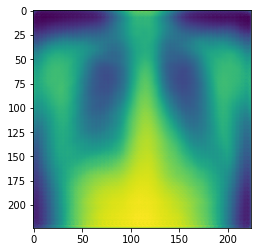

In [24]:
reconstuction = ae.decode(embs[2].mean(0))
plt.imshow(reconstuction.detach().cpu().numpy()[0])
plt.show()

In [35]:
vector = ae_model.quantize_b.embed.mean(1)
vector = vector.unsqueeze(0)
vector = vector.repeat(56,56,1).permute(2,1,0)

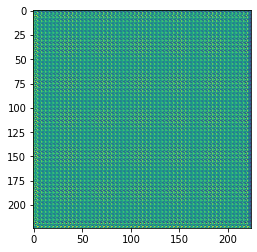

In [36]:
reconstuction = ae.decode(vector)
plt.imshow(reconstuction.detach().cpu().numpy()[0])
plt.show()

In [6]:
ae_model.quantize_conv_b(ae_model.quantize_b.embed)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 512]

In [ ]:
reconstuction = ae.decode(embs[2].mean(0))
plt.imshow(reconstuction.detach().cpu().numpy()[0])
plt.show()

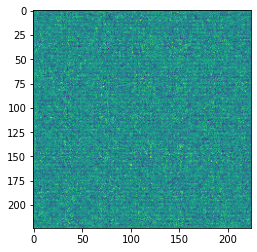

In [26]:
reconstuction = ae.decode(torch.randn((128,56,56)))
plt.imshow(reconstuction.detach().cpu().numpy()[0])
plt.show()

In [58]:
plt.imshow(image.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(reconstruction.detach().cpu().numpy()[0,0])
plt.show()

10

In [60]:
z = ae.encode(image).detach()
image_shape = image.shape
z.requires_grad = True
xp = ae.decode(z, image_shape)
pred = torch.nn.functional.sigmoid(clf((image*p + xp*(1-p))))[:,clf.pathologies.index(target)]
g_c = torch.autograd.grad((pred), xp)[0]


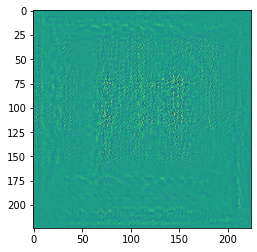

In [61]:
plt.imshow(g_c.detach().cpu().numpy()[0,0])

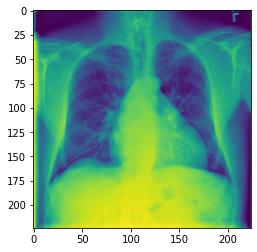

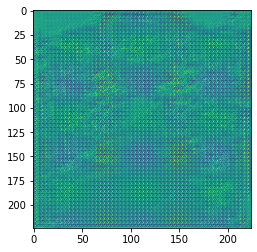

In [106]:
image = torch.tensor(nih_ds[0]['img']).unsqueeze(0)
p = 0
target = "Cardiomegaly"
im = torch.tensor(normalize(image.detach().numpy(),1))
dzdxp = generate_vector(im,target,p,ae,clf)
dzdprediction = dzdxp / dzdxp.norm()

# Set the step size for the gradient ascent
step_size = 0.5
num_steps = 1
# Perform gradient ascent
for i in range(num_steps):
    latent_code = latent_code + dzdprediction * step_size
    reconstruction = ae.decode(latent_code)
    
plt.imshow(image.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(reconstruction.detach().cpu().numpy()[0,0])
plt.show()

In [103]:
dzdprediction.max()

tensor(0.0154)

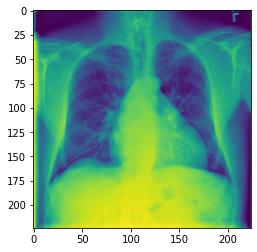

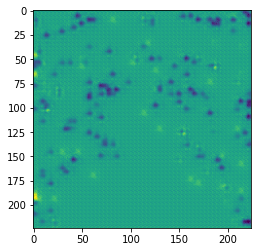

In [108]:
v,_,latent_code = ae_model.encode(image)
codebook_size = 128
perturbation_size = 0.1  # Set the size of the perturbations
latent_code = latent_code + #torch.randint_like(latent_code,0,codebook_size) * perturbation_size
latent_code = latent_code.clamp(0, codebook_size - 1).long()
quant_b = ae_model.quantize_b.embed_code(latent_code)
quant_b = quant_b.permute(0, 3, 1, 2)

gen = ae_model.decode(quant_b)
plt.imshow(image.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(gen.detach().cpu().numpy()[0,0])


In [91]:
latent_code

tensor([[[  2,  36,  19,  ...,  19,  36,  11],
         [  3,  19,  36,  ...,  19,  36,  11],
         [  3,  19,  36,  ..., 127,  36,  11],
         ...,
         [127, 122,  89,  ..., 101,  11,  36],
         [127, 127,  89,  ..., 127,  11,  19],
         [127,  89,   7,  ...,  58,  60, 127]]])

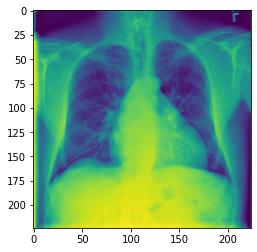

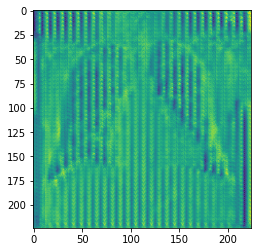

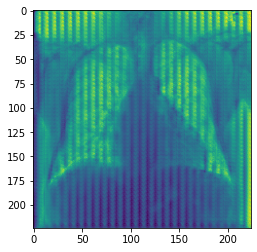

In [73]:
import math

angle = 90 * math.pi / 180  # Convert 10 degrees to radians
rotation_matrix = torch.tensor([[math.cos(angle), -math.sin(angle)],
                                [math.sin(angle), math.cos(angle)]])

rotated_dzdxp = dzdxp.view(dzdxp.size(0), -1, 2).matmul(rotation_matrix)
v_1 = (ae.encode(image))
v = v_1.view(v_1.size(0), -1, 2).matmul(rotation_matrix)
v = v.view(v_1.size())
gen = ae.decode((v),0)
plt.imshow(image.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(gen.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(gen.detach().cpu().numpy()[0,0] - image.detach().cpu().numpy()[0,0])

In [71]:
rotated_dzdxp.shape

torch.Size([1, 200704, 2])

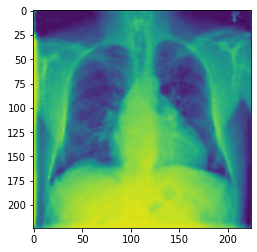

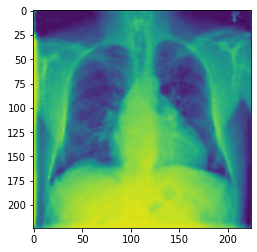

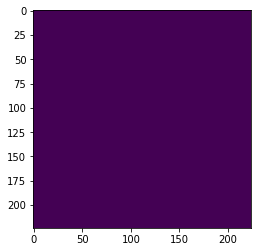

In [64]:
image = torch.tensor(nih_ds[0]['img']).unsqueeze(0)

v,diff,id_b = ae_model.encode(image)
i1=ae_model.decode(v)[0,0].detach().cpu()
plt.imshow(i1)
plt.show()
v_2,diff,id_b = ae_model.encode(image)
i2 = ae_model.decode(v_2)[0,0].detach().cpu()
plt.imshow(i2)
plt.show()
plt.imshow(i1-i2)

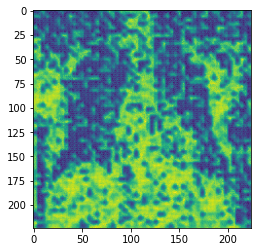

In [21]:
image = torch.tensor(nih_ds[0]['img']).unsqueeze(0)
image_2 = torch.tensor(nih_ds[2]['img']).unsqueeze(0)

v,diff,id_a = ae.encode_(image)

v_n = (v+512*torch.randn_like(v)).permute(0, 2, 3, 1)
quantize, diff, embed_ind = ae_model.quantize_b(v_n)
dec = ae_model.decode(quantize.permute(0, 3, 1, 2))
plt.imshow(dec.detach().cpu().numpy()[0,0])

In [42]:
id_b[0,10,0] += 1
id_b[0,10,0] 

tensor(365)

In [29]:
id_a.shape

torch.Size([1, 56, 56])

In [128]:
model_parameters = filter(lambda p: p.requires_grad, ae_old.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

31120448


In [30]:
ae.base.quantize_conv_b

Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))

In [145]:
image_1 = torch.tensor(nih_ds[500]['img']).unsqueeze(0).to("cuda")
image_2 = torch.tensor(nih_ds[20]['img']).unsqueeze(0).to("cuda")

v_1 = ae.encode(image_1.to("cuda"))[0]
v_2 = ae.encode(image_2.to("cuda"))[0]

In [ ]:
plt.imshow(image_1.detach().cpu().numpy()[0,0])
plt.show()
plt.imshow(image_2.detach().cpu().numpy()[0,0])
plt.show()
gen = ae.decode(v_1+1*v_2,0)
plt.imshow(gen.detach().cpu().numpy()[0])

In [4]:
from torchvision.transforms import Compose
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize, apply_transforms, relabel_dataset, SubsetDataset
from datawrappers import NIH_wrapper, CheX_wrapper, VINBig_wrapper

transforms = Compose([XRayCenterCrop(),XRayResizer(224)])
nih_ds = NIH_wrapper(r"/mnt/mp1/@ais/nih_raw/%ob/",\
    csvpath=r"/mnt/mp1/@ais/nih_raw/%ob/Data_Entry_2017_v2020.csv",\
    bbox_list_path=r"/mnt/mp1/@ais/nih_raw/%ob/BBox_List_2017.csv",\
    unique_patients=True,
    transform=transforms)
relabel_dataset(clf.pathologies,nih_ds,silent=False)

#chex_ds = CheX_wrapper(r"/mnt/mp1/@ais/chexpert_raw/%ob",r"/mnt/mp1/@ais/chexpert_raw/%ob/train.csv",transform=transforms)
#relabel_dataset(clf.pathologies,chex_ds,silent=False)
#chex_ds.labels = np.nan_to_num(chex_ds.labels,0)
#Chexpert_datamodule = torch.utils.data.DataLoader(chex_ds,batch_size=500,pin_memory=False)

vbg_ds = VINBig_wrapper(r"/mnt/mp1/@ais/vinbig/%ob/train",r"/mnt/mp1/@ais/vinbig/%ob/train.csv",transform=transforms)
relabel_dataset(clf.pathologies,vbg_ds,silent=False)
vbg_ds.labels = np.nan_to_num(vbg_ds.labels,0)


Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
{'Pulmonary Fibrosis', 'ILD', 'Lesion', 'Calcification', 'Aortic enlargement', 'Nodule/Mass'} will be dropped
Edema doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Pneumonia doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.
Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [ ]:
def eval(ae, generate_vector, target, data,method=None):
    if method:   
        wandb.init(project="concept_vector_stability",name=str(method)+" "+target)
    else:
        wandb.init(project="concept_vector_stability")
    result = []
    per_sample_table = None
    for sample in data:
        if sample["label"][data.dataset.pathologies.index(target)] == 1: 
            if target not in sample["pathology_masks"].keys():
                #print("no mask found")
                continue
            image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()
            vector = generate_vector(image,target)
            dimage = generate_explanation(sample, vector, target, ae=ae, clf=clf)
            metrics = calc_iou(dimage, sample["pathology_masks"][target])
            recon = ae(image)["out"]
            metrics["mse"] = float(((image-recon)**2).mean().detach().cpu().numpy())
            metrics["mae"] = float(torch.abs(image-recon).mean().detach().cpu().numpy())
            metrics["idx"] = sample["__key__"]
            metrics["method"] = method
            #metrics["p"] = float(p)
            metrics["target"] = target
            if per_sample_table: 
                per_sample_table.add_data(*list(metrics.values()))
            else: 
                per_sample_table = wandb.Table(dataframe=pd.DataFrame(metrics,index=[metrics['idx']]))
            result.append(metrics)
            image = wandb.Image(image, caption="original image", masks= {"predictions":{"mask_data":sample["pathology_masks"][target]["mask"][0]}})
            r_image = wandb.Image(recon,caption="reconstruction")
            mask = wandb.Image(sample["pathology_masks"][target]["mask"][0],caption="gt mask")
            fig = plt.imshow(dimage)
            wandb.log({"mask":mask,"salincy": fig,"original":image,"reconstruction":r_image,"target":target,"vector":vector})
    wandb.log({"res_table":per_sample_table,"total_table":pd.DataFrame(result).groupby("method").agg("mean")})
    return pd.DataFrame(result)

In [ ]:
exp = {"method": "latentshift max", "function": lambda x,y : generate_vector(x,y,ae=ae_model,clf=clf)},
